In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import datetime

In [2]:
epochs = 1000
batch = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.head()

,id,digit,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,4,4,3,0,4,3,3,3,4,4,0,0,1,1,3,4,0,4,2,0,4,0,1,3,1,0,4,1,1,3,...,4,3,4,1,3,0,0,1,3,3,3,0,3,2,2,1,0,1,0,0,3,0,0,4,2,0,3,4,1,1,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,1,4,2,0,3,4,0,0,2,3,4,0,3,4,3,0,2,2,1,4,2,3,3,4,1,2,4,2,0,3,...,4,2,3,0,0,0,0,4,3,2,2,4,2,1,1,1,3,3,1,2,4,4,4,2,2,4,4,0,4,2,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,0,2,1,3,2,2,2,4,1,1,4,1,0,1,3,4,2,2,2,4,1,1,2,0,3,0,2,3,4,0,...,3,0,4,0,3,0,2,0,1,4,2,3,4,4,4,0,2,0,4,4,1,3,0,3,2,0,2,3,0,2,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,3,4,3,1,0,3,2,2,0,3,4,1,0,4,1,2,2,3,2,2,0,2,0,3,0,3,2,4,0,0,...,0,3,0,1,4,1,3,1,2,1,1,1,2,2,2,4,3,4,3,0,4,1,2,4,1,4,0,1,0,4,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,4,2,4,2,1,4,1,1,4,4,0,2,3,4,4,3,3,3,3,4,1,0,3,0,3,0,0,0,1,1,...,2,1,3,2,1,4,2,3,2,2,1,0,4,2,2,1,2,1,0,3,2,2,2,2,1,4,2,1,2,1,4,4,3,2,1,3,4,3,1,2


In [5]:
test.head()

,id,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,2049,L,0,4,0,2,4,2,3,1,0,0,1,0,1,3,4,4,0,0,2,4,4,1,3,3,2,2,4,1,0,1,2,2,1,2,2,1,4,0,...,1,3,1,1,3,3,4,1,3,1,2,4,1,2,0,3,1,2,4,0,2,1,2,4,1,1,3,2,1,0,2,0,4,2,2,4,3,4,1,4
1,2050,C,4,1,4,0,1,1,0,2,2,1,0,3,0,1,1,4,1,2,0,2,2,0,4,3,4,0,2,4,4,2,1,2,4,0,4,2,0,2,...,3,4,2,6,2,2,0,1,2,4,1,1,3,3,2,3,4,2,2,4,3,1,3,3,3,1,3,4,4,2,0,3,2,4,2,4,2,2,1,2
2,2051,S,0,4,0,1,3,2,3,0,2,1,2,0,1,0,3,0,1,4,3,0,0,3,0,4,1,0,3,2,0,4,1,2,0,0,1,3,0,2,...,0,4,4,3,4,1,4,2,3,4,1,2,0,2,2,3,3,1,1,4,1,2,4,0,0,0,0,2,3,2,1,3,2,0,3,2,3,0,1,4
3,2052,K,2,1,3,3,3,4,3,0,0,2,3,2,3,4,4,4,0,1,4,2,2,0,1,4,3,1,3,0,2,3,2,4,3,1,1,4,0,0,...,0,4,1,1,2,3,2,3,3,0,0,1,3,3,0,2,0,0,2,3,2,2,3,1,1,2,4,0,1,2,3,0,3,2,4,1,0,4,4,4
4,2053,W,1,0,1,1,2,2,1,4,1,1,4,3,4,1,2,1,4,3,3,4,0,4,4,2,0,0,0,0,3,4,0,1,4,2,2,2,1,4,...,4,1,3,2,1,2,1,4,4,1,2,3,2,4,2,1,4,3,4,3,0,1,0,1,1,2,1,1,0,2,4,3,1,4,0,2,1,2,3,4


In [6]:
len(test)

20480

In [7]:
train, val = train_test_split(train, test_size=0.2)

col_list = [str(i) for i in range(784)]

train_image_df = train[col_list]
val_image_df = val[col_list]
test_image_df = test[col_list]

train_info = train[['id','letter']]
val_info = val[['id', 'letter']]
test_info = test[['id','letter']]
train_label = train['digit']
val_label = val['digit']

train_arr = train_image_df.values.reshape((len(train), 28, 28))
val_arr = val_image_df.values.reshape((len(val), 28, 28))
test_arr = test_image_df.values.reshape((len(test), 28, 28))

print(train_arr.shape, val_arr.shape, test_arr.shape)

(1638, 28, 28) (410, 28, 28) (20480, 28, 28)


In [8]:
train_image_df.shape, val_image_df.shape, test_image_df.shape

((1638, 784), (410, 784), (20480, 784))

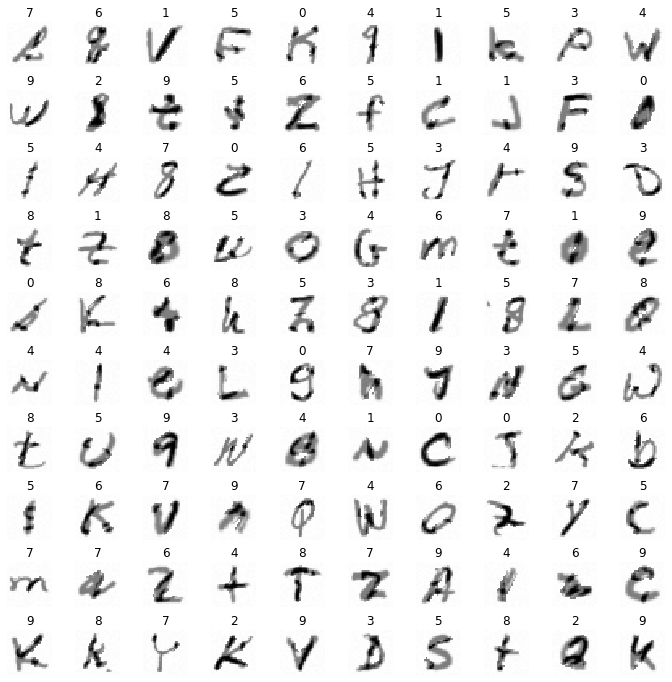

In [9]:
n_rows = 10
n_cols = 10
plt.figure(figsize=(n_cols*1.2, n_rows*1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_rows*row + col
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(train_arr[index,:,:], cmap='binary', interpolation='nearest')
        plt.axis("off")
        plt.title(str(train_label.values[index]), fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [10]:
# def image_filtering(size, data):
#     result = data.copy()
#     for i in range(size):
#         for j in range(28):
#             for k in range(28):
#                 if result[i][j][k] < 80:
#                     result[i][j][k] = 0
#     return result

In [11]:
# train_filtered = image_filtering(len(train_arr),train_arr)
# test_filtered = image_filtering(len(test_arr), test_arr)
# val_filtered = image_filtering(len(val_arr), val_arr)

In [12]:
# n_rows = 10
# n_cols = 10
# plt.figure(figsize=(n_cols*1.2, n_rows*1.2))
# for row in range(n_rows):
#     for col in range(n_cols):
#         index = n_rows*row + col
#         plt.subplot(n_rows, n_cols, index+1)
#         plt.imshow(train_arr[index,:,:], cmap='binary', interpolation='nearest')
#         plt.axis("off")
#         plt.title(str(train_label.values[index]), fontsize=12)
# plt.subplots_adjust(wspace=0.2, hspace=0.5)
# plt.show()

In [13]:
train_img = train_arr[...,tf.newaxis] # add channel
val_img = val_arr[...,tf.newaxis]
test_img = test_arr[...,tf.newaxis] # add channel

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    # rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(
    rescale=1./255.
)

In [20]:
# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_normal', activation='elu', padding='same', input_shape=(28,28,1),
#                                  kernel_regularizer=tf.keras.regularizers.l2(1e-04))) #28x28x8
# model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_normal', activation='elu', padding='same',
#                                  kernel_regularizer=tf.keras.regularizers.l2(1e-04)))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPool2D((2,2)))
# model.add(tf.keras.layers.Dropout(0.5))

# model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_normal', activation='elu', padding='same',
#                                  kernel_regularizer=tf.keras.regularizers.l2(1e-04)))
# # model.add(tf.keras.layers.MaxPool2D((2,2)))
# model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_normal', activation='elu', padding='same',
#                                  kernel_regularizer=tf.keras.regularizers.l2(1e-04)))
# # model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_normal', activation='elu', padding='same'))
# # model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3),kernel_initializer='he_normal', activation='elu', padding='same',
# #                                  kernel_regularizer=tf.keras.regularizers.l2(1e-04)))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPool2D((2,2)))
# model.add(tf.keras.layers.Dropout(0.5))

# model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3) ,kernel_initializer='he_normal', activation='elu', padding='same',
#                                 kernel_regularizer=tf.keras.regularizers.l2(1e-04)))
# model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), kernel_initializer='he_normal', activation='elu', padding='same',
#                                 kernel_regularizer=tf.keras.regularizers.l2(1e-04)))
# model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), kernel_initializer='he_normal', activation='elu', padding='same',
#                                 kernel_regularizer=tf.keras.regularizers.l2(1e-04)))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPool2D((2,2)))
# model.add(tf.keras.layers.Dropout(0.5))

# model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3) ,kernel_initializer='he_normal', activation='elu', padding='same',
#                                  kernel_regularizer=tf.keras.regularizers.l2(1e-04)))
# model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3) ,kernel_initializer='he_normal', activation='elu', padding='same',
#                                  kernel_regularizer=tf.keras.regularizers.l2(1e-04)))
# model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3) ,kernel_initializer='he_normal', activation='elu', padding='same',
#                                  kernel_regularizer=tf.keras.regularizers.l2(1e-04)))
# model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3) ,kernel_initializer='he_normal', activation='elu', padding='same',
#                                  kernel_regularizer=tf.keras.regularizers.l2(1e-04)))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPool2D(2,2))
# model.add(tf.keras.layers.Dropout(0.5))

# # model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5) , kernel_initializer='he_normal', activation='elu', padding='same'))

    
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(256, kernel_initializer='he_normal', activation='elu'))
# model.add(tf.keras.layers.Dense(10, activation='softmax'))


In [21]:
# input_ = tf.keras.layers.Input(shape=(28,28,1))
# conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_normal', activation='elu', padding='same',
#                                  kernel_regularizer=tf.keras.regularizers.l2(1e-04))(input_) #28x28x32
# ## Residual Unit1
# batch1_1 = tf.keras.layers.BatchNormalization()(conv1)
# elu1_1 = tf.keras.layers.ELU()(batch1_1)
# res1_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_normal', padding='same',
#                                  kernel_regularizer=tf.keras.regularizers.l2(1e-04))(elu1_1) #28x28x32
# batch1_2 = tf.keras.layers.BatchNormalization()(res1_1)
# elu1_2 = tf.keras.layers.ELU()(batch1_2)
# res1_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3) ,kernel_initializer='he_normal', padding='same',
#                                  kernel_regularizer=tf.keras.regularizers.l2(1e-04))(elu1_2) #14x14x32
# skip1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same')(conv1)
# res1 = tf.keras.layers.Add()([res1_2, skip1])

# ## Residual Unit2
# batch2_1 = tf.keras.layers.BatchNormalization()(res1)
# elu2_1 = tf.keras.layers.ELU()(batch2_1)
# res2_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_normal', padding='same',
#                                  kernel_regularizer=tf.keras.regularizers.l2(1e-04))(elu2_1) # 14x14x32
# batch2_2 = tf.keras.layers.BatchNormalization()(res2_1)
# elu2_2 = tf.keras.layers.ELU()(batch2_2)
# res2_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_normal', padding='same',
#                                  kernel_regularizer=tf.keras.regularizers.l2(1e-04))(elu2_2) #14x14x64
# skip2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same')(res1)
# res2 = tf.keras.layers.Add()([res2_2, skip2])
# pool2 = tf.keras.layers.MaxPool2D((2,2))(res2) #7x7x64
# drop2 = tf.keras.layers.Dropout(0.3)(pool2)

# ## Residual Unit3
# batch3_1 = tf.keras.layers.BatchNormalization()(drop2)
# elu3_1 = tf.keras.layers.ELU()(batch3_1)
# res3_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), kernel_initializer='he_normal', padding='same',
#                                  kernel_regularizer=tf.keras.regularizers.l2(1e-04))(elu3_1) # 7x7x64
# batch3_2 = tf.keras.layers.BatchNormalization()(res3_1)
# elu3_2 = tf.keras.layers.ELU()(batch3_2)
# res3_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3),kernel_initializer='he_normal', activation='elu', padding='same',
#                                  kernel_regularizer=tf.keras.regularizers.l2(1e-04))(elu3_2) #3x3x128
# skip3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1),padding='same')(drop2)
# res3 = tf.keras.layers.Add()([res3_2, skip3])


# ## Residual Unit4
# batch4_1 = tf.keras.layers.BatchNormalization()(res3)
# elu4_1 = tf.keras.layers.ELU()(batch4_1)
# res4_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), kernel_initializer='he_normal', padding='same',
#                                  kernel_regularizer=tf.keras.regularizers.l2(1e-04))(elu4_1) # 7x7x64
# batch4_2 = tf.keras.layers.BatchNormalization()(res4_1)
# elu4_2 = tf.keras.layers.ELU()(batch4_2)
# res4_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3),kernel_initializer='he_normal', activation='elu', padding='same',
#                                  kernel_regularizer=tf.keras.regularizers.l2(1e-04))(elu4_2) #3x3x128
# skip4 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1),padding='same')(res3)
# res4 = tf.keras.layers.Add()([res4_2, skip4])
# pool4 = tf.keras.layers.MaxPool2D((2,2))(res4)
# drop4 = tf.keras.layers.Dropout(0.3)(pool4)

# ## Residual Unit5
# batch5_1 = tf.keras.layers.BatchNormalization()(drop4)
# elu5_1 = tf.keras.layers.ELU()(batch5_1)
# res5_1 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), kernel_initializer='he_normal', padding='same',
#                                  kernel_regularizer=tf.keras.regularizers.l2(1e-04))(elu5_1) # 7x7x64
# batch5_2 = tf.keras.layers.BatchNormalization()(res5_1)
# elu5_2 = tf.keras.layers.ELU()(batch5_2)
# res5_2 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3),kernel_initializer='he_normal', activation='elu', padding='same',
#                                  kernel_regularizer=tf.keras.regularizers.l2(1e-04))(elu5_2) #3x3x128
# skip5 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(drop4)
# res5 = tf.keras.layers.Add()([res5_2, skip5])

# ## Residual Unit6
# batch6_1 = tf.keras.layers.BatchNormalization()(res5)
# elu6_1 = tf.keras.layers.ELU()(batch6_1)
# res6_1 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), kernel_initializer='he_normal', padding='same',
#                                  kernel_regularizer=tf.keras.regularizers.l2(1e-04))(elu6_1) # 7x7x64
# batch6_2 = tf.keras.layers.BatchNormalization()(res6_1)
# elu6_2 = tf.keras.layers.ELU()(batch6_2)
# res6_2 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3),kernel_initializer='he_normal', activation='elu', padding='same',
#                                  kernel_regularizer=tf.keras.regularizers.l2(1e-04))(elu6_2) #3x3x128
# skip6 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(res5)
# res6 = tf.keras.layers.Add()([res6_2, skip6])
# pool6 = tf.keras.layers.MaxPool2D((2,2))(res6)
# drop6 = tf.keras.layers.Dropout(0.3)(pool6)

# ## Classification Unit
# flatten = tf.keras.layers.Flatten()(drop6)
# drop4 = tf.keras.layers.Dropout(0.5)(flatten)
# dense1 = tf.keras.layers.Dense(256, activation='elu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(1e-04))(drop4)
# output = tf.keras.layers.Dense(10 ,activation='softmax')(dense1)

In [22]:
input_ = tf.keras.layers.Input(shape=(28,28,1))
conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_normal', activation='elu', padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l2(1e-04))(input_) #28x28x32
## Residual Unit1
batch1_1 = tf.keras.layers.BatchNormalization()(conv1)
elu1_1 = tf.keras.layers.ELU()(batch1_1)
res1_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l2(1e-04))(elu1_1) #28x28x32
batch1_2 = tf.keras.layers.BatchNormalization()(res1_1)
elu1_2 = tf.keras.layers.ELU()(batch1_2)
res1_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3) , padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l2(1e-04))(elu1_2) #14x14x32
batch1_3 = tf.keras.layers.BatchNormalization()(res1_2)
elu1_3 = tf.keras.layers.ELU()(batch1_3)
res1_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1) , padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l2(1e-04))(elu1_3) #14x14x32                                 
skip1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same')(conv1)
res1 = tf.keras.layers.Add()([res1_3, skip1])
drop1 = tf.keras.layers.Dropout(0.2)(res1)

## Residual Unit2
batch2_1 = tf.keras.layers.BatchNormalization()(drop1)
elu2_1 = tf.keras.layers.ELU()(batch2_1)
res2_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l2(1e-04))(elu2_1) # 14x14x32
batch2_2 = tf.keras.layers.BatchNormalization()(res2_1)
elu2_2 = tf.keras.layers.ELU()(batch2_2)
res2_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l2(1e-04))(elu2_2) #14x14x64
batch2_3 = tf.keras.layers.BatchNormalization()(res2_2)
elu2_3 = tf.keras.layers.ELU()(batch2_3)
res2_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l2(1e-04))(elu2_3) #14x14x64                          
skip2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same')(drop1)
res2 = tf.keras.layers.Add()([res2_3, skip2])
pool2 = tf.keras.layers.MaxPool2D((2,2))(res2) #7x7x64
drop2 = tf.keras.layers.Dropout(0.5)(pool2)

## Residual Unit3
batch3_1 = tf.keras.layers.BatchNormalization()(drop2)
elu3_1 = tf.keras.layers.ELU()(batch3_1)
res3_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l2(1e-04))(elu3_1) # 7x7x64
batch3_2 = tf.keras.layers.BatchNormalization()(res3_1)
elu3_2 = tf.keras.layers.ELU()(batch3_2)
res3_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l2(1e-04))(elu3_2) #3x3x128
batch3_3 = tf.keras.layers.BatchNormalization()(res3_2)
elu3_3 = tf.keras.layers.ELU()(batch3_3)
res3_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l2(1e-04))(elu3_3) #3x3x128                            
skip3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(pool2)
res3 = tf.keras.layers.Add()([res3_3, skip3])
drop3 = tf.keras.layers.Dropout(0.2)(res3)

## Residual Unit4
batch4_1 = tf.keras.layers.BatchNormalization()(drop3)
elu4_1 = tf.keras.layers.ELU()(batch4_1)
res4_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l2(1e-04))(elu4_1) # 7x7x64
batch4_2 = tf.keras.layers.BatchNormalization()(res4_1)
elu4_2 = tf.keras.layers.ELU()(batch4_2)
res4_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l2(1e-04))(elu4_2) #3x3x128
batch4_3 = tf.keras.layers.BatchNormalization()(res4_2)
elu4_3 = tf.keras.layers.ELU()(batch4_3)
res4_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l2(1e-04))(elu4_3) #3x3x128                                 
skip4 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(drop3)
res4 = tf.keras.layers.Add()([res4_3, skip4])
pool4 = tf.keras.layers.MaxPool2D((2,2))(res4)
drop4 = tf.keras.layers.Dropout(0.5)(pool4)
## Residual Unit5
batch5_1 = tf.keras.layers.BatchNormalization()(drop4)
elu5_1 = tf.keras.layers.ELU()(batch5_1)
res5_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l2(1e-04))(elu5_1) # 7x7x64
batch5_2 = tf.keras.layers.BatchNormalization()(res5_1)
elu5_2 = tf.keras.layers.ELU()(batch5_2)
res5_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l2(1e-04))(elu5_2) #3x3x128
batch5_3 = tf.keras.layers.BatchNormalization()(res5_2)
elu5_3 = tf.keras.layers.ELU()(batch5_3)
res5_3 = tf.keras.layers.Conv2D(filters=512, kernel_size=(1,1), padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l2(1e-04))(elu5_3) #3x3x128                                 
skip5 = tf.keras.layers.Conv2D(filters=512, kernel_size=(1,1),padding='same')(drop4)
res5 = tf.keras.layers.Add()([res5_3, skip5])
pool5 = tf.keras.layers.MaxPool2D((2,2))(res5)
drop5 = tf.keras.layers.Dropout(0.2)(pool5)

## Residual Unit6
batch6_1 = tf.keras.layers.BatchNormalization()(drop5)
elu6_1 = tf.keras.layers.ELU()(batch6_1)
res6_1 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l2(1e-04))(elu6_1) # 7x7x64
batch6_2 = tf.keras.layers.BatchNormalization()(res6_1)
elu6_2 = tf.keras.layers.ELU()(batch6_2)
res6_2 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l2(1e-04))(elu6_2) #3x3x128
batch6_3 = tf.keras.layers.BatchNormalization()(res6_2)
elu6_3 = tf.keras.layers.ELU()(batch6_3)
res6_3 = tf.keras.layers.Conv2D(filters=512, kernel_size=(1,1), padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l2(1e-04))(elu6_3) #3x3x128                                 
skip6 = tf.keras.layers.Conv2D(filters=512, kernel_size=(1,1),padding='same')(drop5)
res6 = tf.keras.layers.Add()([res6_3, skip6])
pool6 = tf.keras.layers.MaxPool2D((2,2))(res6)
drop6 = tf.keras.layers.Dropout(0.5)(pool6)

## Classification Unit
flatten = tf.keras.layers.Flatten()(drop6)
drop4 = tf.keras.layers.Dropout(0.5)(flatten)
dense1 = tf.keras.layers.Dense(256, activation='elu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(1e-04))(drop4)
output = tf.keras.layers.Dense(10 ,activation='softmax')(dense1)

In [23]:
model = tf.keras.Model(inputs = [input_], outputs = [output])

In [24]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

In [25]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("emnist_best.h5", save_best_only=True, monitor='val_accuracy', mode='auto')

In [26]:
log_dir = "logs/my_board/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [27]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Nadam(epsilon=1e-04), metrics=["accuracy"])

In [28]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
elu (ELU)                       (None, 28, 28, 64)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [29]:
history = model.fit_generator(train_datagen.flow(train_img, train_label, shuffle=True), epochs=epochs, validation_data=test_datagen.flow(val_img, val_label),
                              steps_per_epoch=len(train_img)/32, validation_steps=len(val_img)/32, callbacks=[checkpoint_cb])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/1000
52/51 [==============================] - 3s 59ms/step - loss: 6.3027 - accuracy: 0.0910 - val_loss: 2.7223 - val_accuracy: 0.0927
Epoch 2/1000
52/51 [==============================] - 2s 41ms/step - loss: 4.0851 - accuracy: 0.1013 - val_loss: 2.8189 - val_accuracy: 0.1268
Epoch 3/1000
52/51 [==============================] - 2s 35ms/step - loss: 3.6787 - accuracy: 0.0812 - val_loss: 2.7656 - val_accuracy: 0.0927
Epoch 4/1000
52/51 [==============================] - 2s 35ms/step - loss: 3.1338 - accuracy: 0.1056 - val_loss: 2.6559 - val_accuracy: 0.0951
Epoch 5/1000
52/51 [==============================] - 2s 35ms/step - loss: 2.9737 - accuracy: 0.0965 - val_loss: 2.6539 - val_accuracy: 0.1073
Epoch 6/1000
52/51 [==============================] - 2s 36ms/step - loss: 2.8433 - accuracy: 0.0983 - val_loss: 2.6261 - val_accuracy: 0.1073
Epoch 7/1000
52/51 [==============================] - 2s 41ms/step

In [30]:
acc = history.history['val_accuracy']
best = np.max(acc)
print(best)

0.8804877996444702


## Model Tuning
- 앞부분 Residual Unit 한 단계만 적용해보기
- output 64인 conv2D layer 늘려야 할듯

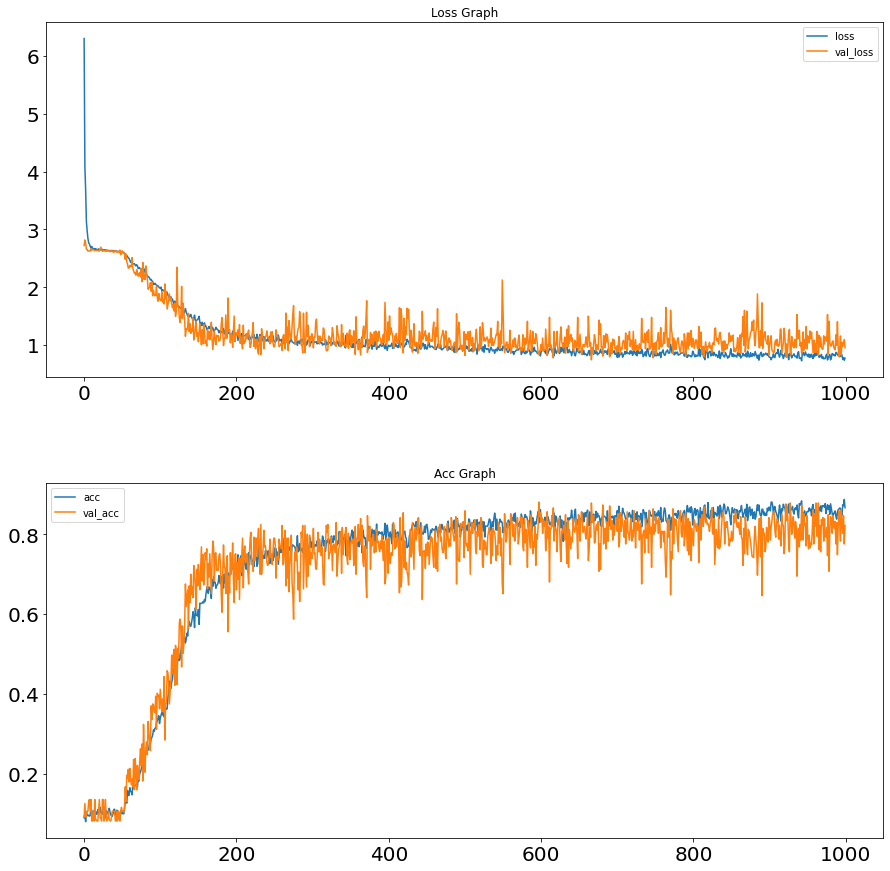

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
fig, ax = plt.subplots(2, 1, figsize = (15,15))
fig.subplots_adjust(hspace = 0.3)
ax[0].set_title("Loss Graph")
ax[0].plot(loss, label='loss')
ax[0].plot(val_loss, label='val_loss')
ax[0].legend()
ax[0].tick_params(axis = 'both', labelsize = 20)
ax[0].tick_params(axis = 'both', labelsize = 20)
ax[1].set_title("Acc Graph")
ax[1].plot(acc, label='acc')
ax[1].plot(val_acc, label='val_acc')
ax[1].legend()
ax[1].tick_params(axis = 'both', labelsize = 20)
ax[1].tick_params(axis = 'both', labelsize = 20)

In [32]:
np.max(history.history['val_accuracy'])

0.8804877996444702

In [33]:
# len(digit)

In [34]:
submission = pd.read_csv('submission.csv')

In [35]:
test_img = test_img/255.

In [36]:
model = tf.keras.models.load_model('emnist_best.h5')

In [37]:
result = model.predict(test_img)

In [38]:
digit = np.argmax(result, axis=1)

In [39]:
result

array([[3.0346311e-05, 7.1248763e-08, 4.0192038e-04, ..., 9.2416053e-10,
        9.5427537e-04, 1.4596520e-09],
       [3.3116546e-02, 2.7915704e-04, 1.1688349e-02, ..., 8.1134038e-03,
        1.4320831e-01, 9.4270967e-02],
       [1.5105725e-05, 2.9751343e-10, 7.8391344e-07, ..., 5.1519766e-10,
        9.9995458e-01, 5.0654176e-08],
       ...,
       [1.6728098e-08, 9.5327088e-13, 8.5046076e-06, ..., 4.6744343e-15,
        8.9076375e-06, 1.7490488e-15],
       [5.4088778e-06, 3.2187736e-10, 7.8043386e-06, ..., 7.8424671e-09,
        9.9974364e-01, 1.4196528e-06],
       [9.9709594e-01, 6.3846687e-07, 4.1491017e-04, ..., 8.6811173e-04,
        5.1828396e-05, 1.6121134e-06]], dtype=float32)

In [40]:
digit = np.argmax(result, axis=1)

In [41]:
submission.head()

,id,digit
0,2049,0
1,2050,0
2,2051,0
3,2052,0
4,2053,0


In [42]:
submission.digit = digit

In [43]:
submission.head()

,id,digit
0,2049,6
1,2050,5
2,2051,8
3,2052,0
4,2053,3


In [44]:
submission.to_csv('sub9.csv', index=False)

In [45]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])